In [1]:
import numpy as np
import math
import pymeshlab
import potpourri3d as pp3d
import polyscope as ps
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3

In [6]:
#ms = pymeshlab.MeshSet()
fname = 'geometry/spot_triangulated.stl'
#fname = 'geometry/twoWonkyTriangles.stl'
#ms.load_new_mesh(fname)
#V, F = pp3d.read_mesh(fname)
tbm = trianglebarmesh.TriangleBarMesh(fname)
#n = ms.current_mesh().face_normal_matrix()
V = tbm.GetVertices()
F = tbm.GetFaces()
n = tbm.GetNormals()

In [10]:
tbm.faces[1].bars

[7885, 7887, 7919]

In [12]:
tbm.bars[7885].faceright

1

In [4]:
def pointOnEdge(i, l):
    pt1 = tbm.bars[i].GetNodeFore(True).p
    pt2 = tbm.bars[i].GetNodeFore(False).p
    vec12 = (pt2[0]-pt1[0],pt2[1]-pt1[1],pt2[2]-pt1[2])
    ptl = P3(pt1[0]+l*vec12[0],pt1[1]+l*vec12[1],pt1[2]+l*vec12[2])
    return ptl

def P3list2array(P3list):
    pts =[]
    for p in P3list:
        pts.append((p.x,p.y,p.z))
    return np.array(pts)

In [5]:
# axis is a b
# incoming at d = Along(lam, a, b)
# incoming from c to d 
# incoming (d - c).(b - a) = |d-c||b-a|cos(theta) = |d-c|I
# I = |b-a|cos(theta) = (d - c).(b - a)/|d-c|

# triangle on right hand side is to e
# outgoing to x where x = Along(q, a, e) or x = Along(q, b, e)
# Solve (x - d).(b - a) = |x-d||b-a|cos(theta) = |x-d|I

# Set d = 0, v = b - a
# x.v = |x|I  where x = a + (e - a)*q = a + f*q
# x.x I^2 = (x.v)^2

# x.x I^2 = (a + f*q)^2 I^2 = q^2 f^2 I^2 + 2q a.f I^2 + a^2 I^2
#   =
# (x.v)^2 = (a.v + f.v*q)^2 = q^2 (f.v)^2 + 2q (a.v)(f.v) + (a.v)^2
# q^2 ((f.v)^2 - f^2 I^2) + 2q ((a.v)(f.v) - a.f I^2) + (a.v)^2 - a^2 I^2

def Square(X):
    return X*X
def TOL_ZERO(X):
    if not (abs(X) < 0.0001):
        print("TOL_ZERO fail", X)

def GeoCrossAxisE(a, Vae, Vab, Isq, Isgn):
    # Solve: Isq*x.Lensq() - Square(P3.Dot(x, Vab)) = 0   for x = a + Vae*q
    # 0 = Isq*(a^2 + 2q a.Vae + q^2 Vae^2) - (a.Vab + Vae.Vab q)^2
    #   = Isq*(a^2 + 2q adf + q^2 Vae^2) - (adv + fdv q)^2

    fdv = P3.Dot(Vae, Vab)
    adv = P3.Dot(a, Vab)
    adf = P3.Dot(a, Vae)
    qA = Square(fdv) - Vae.Lensq()*Isq
    qB2 = adv*fdv - adf*Isq
    qC = Square(adv) - a.Lensq()*Isq
    if abs(qA) <= abs(qB2)*1e-7:
        if qB2 == 0:
            return -1.0
        q = -qC/(2*qB2)
    else:
        qdq = Square(qB2) - qA*qC
        if qdq < 0.0:
            #print("qdq", qdq)
            return -1.0
        qs = math.sqrt(qdq) / qA
        qm = -qB2 / qA
        q = qm + qs*Isgn
    # q = qs +- qm,  x = a + Vae*q,  Dot(x, Vab) same sign as Dot(Vcd, Vab)
    if abs(q) < 100:
        TOL_ZERO(qA*Square(q) + qB2*2*q + qC)
    return q

#
# This is the basic function that crosses from one triangle to the next
#
def GeoCrossAxis(Ga, Gb, Gc, lam, Ge):
    Vab = Gb - Ga
    Gd = Ga + Vab*lam
    Vcd = Gd - Gc
    cdDab = P3.Dot(Vcd, Vab)
    Isq = Square(cdDab) / Vcd.Lensq()
    Isgn = -1 if cdDab < 0 else 1
    qVae = GeoCrossAxisE(Ga - Gd, Ge - Ga, Vab, Isq, Isgn)
    qVbe = GeoCrossAxisE(Gb - Gd, Ge - Gb, -Vab, Isq, -Isgn)
    bAEcrossing = (abs(qVae - 0.5) < abs(qVbe - 0.5))
    q = qVae if bAEcrossing else qVbe
    Gx = (Ga + (Ge - Ga)*q) if bAEcrossing else (Gb + (Ge - Gb)*q)
    Dx = Gx - Gd
    TOL_ZERO(Isq - Square(P3.Dot(Dx, Vab)/Dx.Len()))
    TOL_ZERO(P3.Dot(Vcd, Vab)/Vcd.Len() - P3.Dot(Dx, Vab)/Dx.Len())
    return bAEcrossing, q, Gx

In [6]:
# This is the iterative function that goes from bar to bar through the mesh
# c=from point, bar the crossing edge, lam the point on the bar, and bGoRight is the crossing direction
#
def GeoCrossBar(c, bar, lam, bGoRight, bPrintvals=False):
    bEnd = False
    Na, Nb = bar.nodeback, bar.nodefore
    if bGoRight:
        if bar.barforeright == None:
            bEnd = True
            Ne = trianglebarmesh.TriangleNode(P3(bar.nodefore.p.x+0.01,bar.nodefore.p.y+0.01,bar.nodefore.p.z+0.01),-1)
        else:
            Ne = bar.barforeright.GetNodeFore(bar.barforeright.nodeback == bar.nodefore)
    else:
        if bar.barbackleft == None:
            bEnd = True
            Ne = trianglebarmesh.TriangleNode(P3(bar.nodeback.p.x+0.01,bar.nodeback.p.y+0.01,bar.nodeback.p.z+0.01),-1)
        else:
            Ne = bar.barbackleft.GetNodeFore(bar.barbackleft.nodeback == bar.nodeback)
    d = Na.p + (Nb.p - Na.p)*lam
    if bPrintvals:
        print("\n", (Na.p, Nb.p, c, lam, Ne.p))
    bAEcrossing, q, Gx = GeoCrossAxis(Na.p, Nb.p, c, lam, Ne.p)
    if bGoRight:
        if bAEcrossing:
            if not bEnd:
                bar = bar.barforeright.GetForeRightBL(bar.barforeright.nodeback == Nb)
                lam = q if bar.nodeback == Na else 1-q
                bGoRight = (bar.nodeback == Na)
            else:
                bar = None
        else:
            if not bEnd:
                bar = bar.barforeright
                lam = q if bar.nodeback == Nb else 1-q
                bGoRight = not (bar.nodeback == Nb)
            else:
                bar = None
    else:
        if bAEcrossing:
            if not bEnd:
                bar = bar.barbackleft
                lam = q if bar.nodeback == Na else 1-q
                bGoRight = not (bar.nodeback == Na)
            else:
                bar = None
        else:
            if not bEnd:
                bar = bar.barbackleft.GetForeRightBL(bar.barbackleft.nodeback == Na)
                lam = q if bar.nodeback == Nb else 1-q
                bGoRight = (bar.nodeback == Nb)
            else:
                bar = None
    if not bEnd:
        c = bar.nodeback.p + (bar.nodefore.p - bar.nodeback.p)*lam
        TOL_ZERO((c - Gx).Len())
    else:
        c = None
    if bPrintvals:
        print("d,c", (d, c))
    
    return (d, bar, lam, bGoRight)



In [7]:
seedVec = (0.1,0.1,1,0)
geopath = []
lam=0.6
bar = tbm.bars[1]
bGoRight = True
ptD = pointOnEdge(1,1-lam)

c = P3(ptD.x-seedVec[0],ptD.y-seedVec[1],ptD.z-seedVec[2])

geopath.append(c)
for i in range(1000):
    #print('bar: ',bar.i)
    if bar != None:
        c, bar, lam, bGoRight = GeoCrossBar(c, bar, lam, bGoRight,False)
        geopath.append(c)
    else:
        print('Edge reached')
        break
#print(geopath)

Edge reached


In [8]:
ps.init()
for i in range(len(tbm.bars)):
    pt1 = tbm.bars[i].GetNodeFore(True).p
    pt2 = tbm.bars[i].GetNodeFore(False).p
    nodes = np.array([(pt1.x,pt1.y,pt1.z),(pt2.x,pt2.y,pt2.z)])
    ps_net = ps.register_curve_network('bar'+str(i), nodes, 'line',radius = 0.002, enabled=False)
ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_cloud = ps.register_point_cloud("vertices", V)
#ps_cloud = ps.register_point_cloud("pts", pts)
ps_net = ps.register_curve_network('geodesic', P3list2array(geopath), 'line')
ps.get_surface_mesh("my mesh").add_vector_quantity("normals", n, defined_on='faces', color=(1, 0.5, 0.5))
ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6


In [15]:
v = None
if v:
    print(v)
else:
    print('bar')

bar


In [9]:
def GenerateSphere(rad, N, M):
    longs = [ math.radians(i/N*360.0)  for i in range(N) ]
    lats = [ math.radians(i/M*180.0 - 90.0)  for i in range(M+1) ]
    rpts = [ P3(0,0,-rad)  for i in range(N) ]
    flat9triangles = [ ]
    for i in range(1, M+1):
        lat = math.radians(i/M*180.0 - 90.0)
        sinlat = math.sin(lat) if i != M else 1
        coslat = math.cos(lat) if i != M else 0
        rptsN = [ P3(coslat*math.sin(lng), coslat*math.cos(lng), sinlat)*rad  for lng in longs ]
        rp0, rpN0 = rpts[-1], rptsN[-1]
        for rp, rpN in zip(rpts, rptsN):
            if i != 1:
                flat9triangles.append(tuple(rp0)+tuple(rp)+tuple(rpN))
            if i != M:
                flat9triangles.append(tuple(rp0)+tuple(rpN)+tuple(rpN0))
            rp0, rpN0 = rp, rpN
        rpts = rptsN
    return flat9triangles


flat9triangles = GenerateSphere(5, 10, 10)
tbm = trianglebarmesh.TriangleBarMesh(flat9triangles=flat9triangles)

270

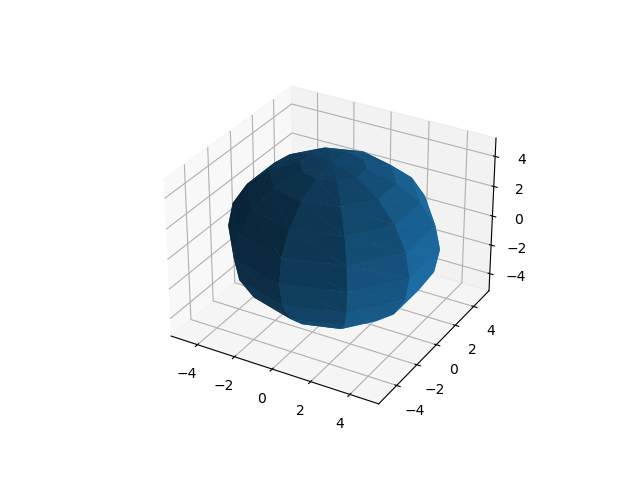

In [10]:


%matplotlib widget
from matplotlib import pyplot as plt
import numpy

tris = tbm.GetBarMeshTriangles()

X = numpy.array(sum(((tri[0][0], tri[1][0], tri[2][0])  for tri in tris), start=()))
Y = numpy.array(sum(((tri[0][1], tri[1][1], tri[2][1])  for tri in tris), start=()))
Z = numpy.array(sum(((tri[0][2], tri[1][2], tri[2][2])  for tri in tris), start=()))
triangles = [ [i,i+1,i+2]  for i in range(0, len(X), 3)]

ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, triangles=triangles, linewidths=0.2);
len(tbm.bars)



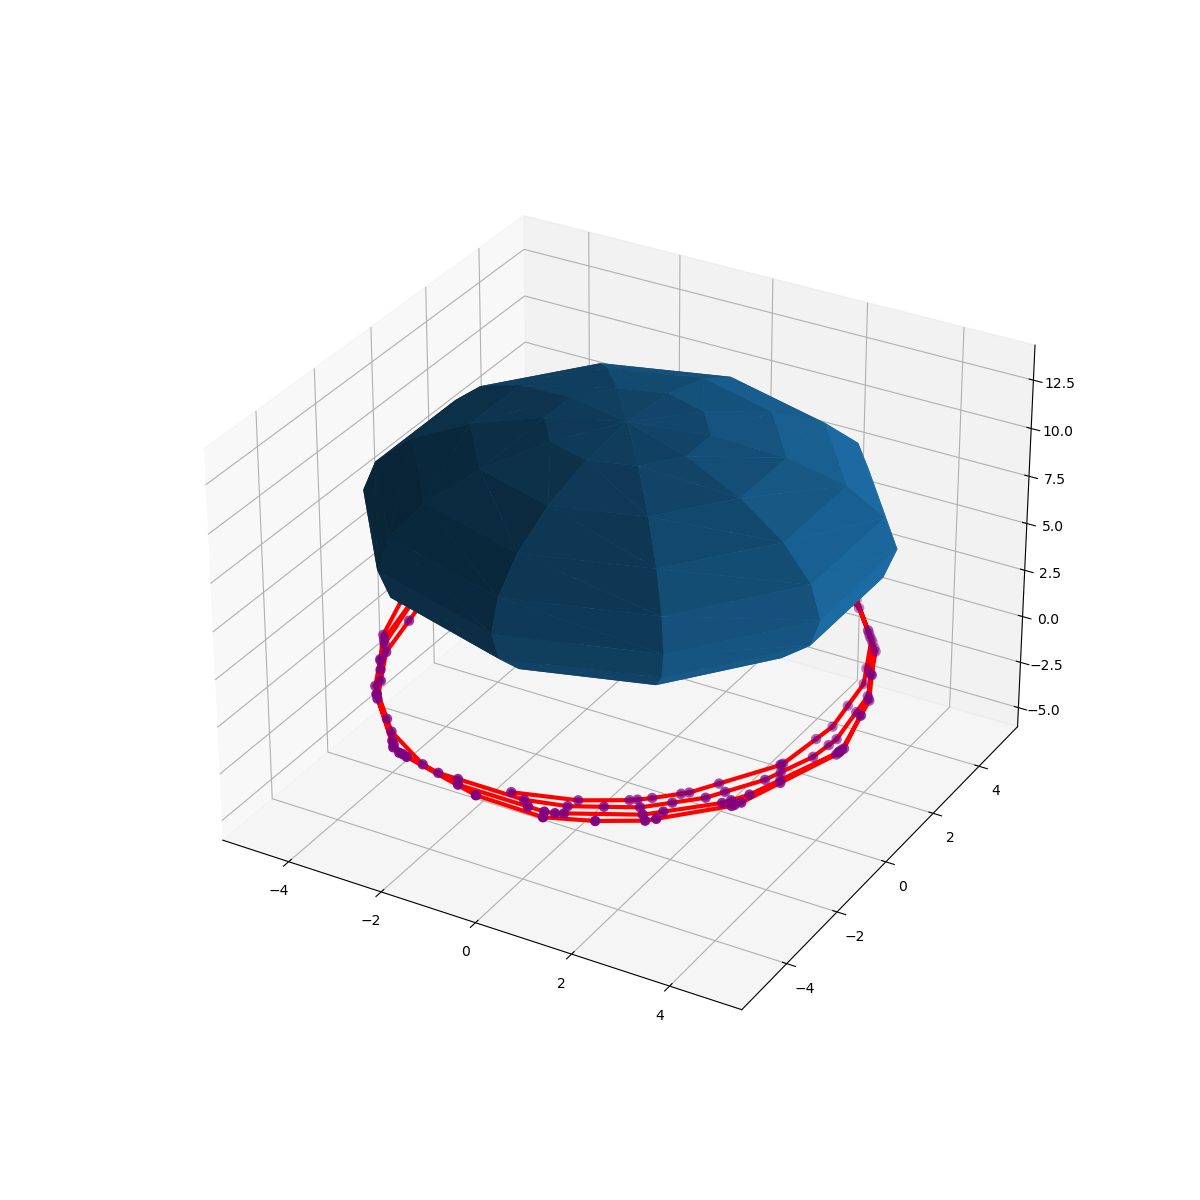

In [14]:
bar = tbm.bars[100]
Nc = bar.barbackleft.GetNodeFore(bar.barbackleft.nodeback == bar.nodeback)
bGoRight = True
lam = 0.4
c = Nc.p + P3(0,0,0.02)
geoseq = [ ]
for i in range(160):
    c, bar, lam, bGoRight = GeoCrossBar(c, bar, lam, bGoRight)
    geoseq.append(c)
    
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

tris = tbm.GetBarMeshTriangles()
X = numpy.array(sum(((tri[0][0], tri[1][0], tri[2][0])  for tri in tris), start=()))
Y = numpy.array(sum(((tri[0][1], tri[1][1], tri[2][1])  for tri in tris), start=()))
Z = numpy.array(sum(((tri[0][2], tri[1][2], tri[2][2])  for tri in tris), start=()))
triangles = [ [i,i+1,i+2]  for i in range(0, len(X), 3)]

ax.plot_trisurf(X, Y, Z+8, triangles=triangles, linewidths=0.2);
xs, ys, zs = [ p[0]  for p in geoseq ], [ p[1]  for p in geoseq ], [ p[2]  for p in geoseq ]
ax.plot(xs, ys, zs, color="red", linewidth=3);
ax.scatter(xs, ys, zs, color="purple", linewidth=3);



In [16]:


# ab is the triangle edge axis, d is crossing point on axis coming from c
# e is point of triangle to right of axis
Ga = P3(0,0,0)
Gb = P3(0,1,0)
lam = 0.31
Gc = P3(-1,0.3,0)
Ge = P3(1,0.5,0)



In [10]:


x0, x1
# Solve (x - d).(b - a) = |x-d||b-a|cos(theta) = |x-d|I
math.sqrt(Isq), P3.Dot(x0, Vab)/x0.Len(), P3.Dot(x1, Vab)/x1.Len()



NameError: name 'x0' is not defined

In [35]:
tbm.bars[0].GetForeRightBL(False)

In [36]:
tbm.GetBarMeshTriangles()

[(P3(0.0, 0.0, 0.0), P3(1.0, 0.0, 0.0), P3(0.0, 1.0, 0.0)),
 (P3(0.0, 1.0, 0.0), P3(1.0, 0.0, 0.0), P3(1.0, 1.100000023841858, -0.25))]

In [41]:
tbm.bars[0].GetNodeFore(False).p

0.0

In [6]:
ms.show_polyscope() 